In [58]:
# Posiblemente tengas que instalar ciertos paquetes de procesamiento
# !pip install scipy sickit-image tqdm

import numpy as np
import pandas as pd
from scipy import integrate
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML
from tqdm.autonotebook import tqdm

# plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline
%config Completer.use_jedi = False

import matplotlib as mpl

cmap_greys = mpl.cm.Greys(np.linspace(0,1,20))
cmap_greys = mpl.colors.ListedColormap(cmap_greys[5:,:-1][::-1])

In [59]:
from skimage.io import imread
from skimage.transform import rescale
from skimage import filters

# Regularización

Veremos el uso de técnicas de regularización en un problema de regresión lineal con aplicación en suavizamiento de imágenes. La idea es la siguiente. 

1. Tenemos una imagen que ha sido transmitida a nosotros por medio de un canal ruidoso. 
1. El ruido proviene de la distancia que ésta imagen tiene que cruzar para llegar a nuestro sistema. 
1. Además, la imagen ha sido comprimida para garantizar que llegue lo antes posible. 
1. La cámara que toma la imagen es una cámara digital vieja, por lo tanto es de baja resolución y aplica un suavizamiento para _mejorar_ la cohesión de la imagen. 
1. La imagen fue tomada en la noche.

La forma en que la cámara procesa la imágen está bien entendida. Y podemos pensar en la acción de la cámara como una transformación lineal representada por una matriz $A \in \mathbb{R}^{N^2\times N^2}$ donde $N$ es el número de pixeles de la imagen original. La matriz representa cierta acción entre todas las parejas de píxeles. 

In [ ]:
N = 55
sigma = 8 * .15

X, Y = np.meshgrid(range(N), range(N))
coords = np.hstack([X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1)])

r = squareform(pdist(coords, 'euclidean'))

def kernel_gaussian(r, sigma = 1, N = 10):
    delta_2 = (1/N)**2
    z = 2 * np.pi * sigma**2
    return delta_2 * np.exp(-r**2/(2 * sigma**2))/z

A = kernel_gaussian(r, sigma = sigma, N = N)

La imagen (que no conocemos) la denotamos $p_x \in \mathbb{R}^{N\times N}$ y la pensamos como un vector largo $x \in \mathbb{R}^{N^2 \times 1}.$ La imagen que nosotros observaríamos (en un canal de transmisión limpio) sería $A x$. Sin embargo lo que nosotros recibimos es 

$$ y = A x + \epsilon\,,$$

donde $\epsilon \sim \mathsf{N}(0, \sigma^2)$. 

In [48]:
def genera_imagen():
    # Leemos la imagen
    image = imread('../images/trooper.png', as_gray = True)

    # Desenfocamos la imagen
    image_blurred = filters.gaussian(image, (sigma,sigma))
    image_y = rescale(image_blurred, scale= .15)
    image_y = image_y[:N,:N]
    y = image_y.flatten().reshape(-1,1)

    sigma_noise = 0.45 * y.max()
    sigma_noise

    np.random.seed(1)
    y_noisy = y + (y >= .3) * sigma_noise * np.random.normal(size = [N**2,1]) +\
             (y <= .3) * np.random.uniform(0,.5,size = [N**2, 1])
    
    return y_noisy

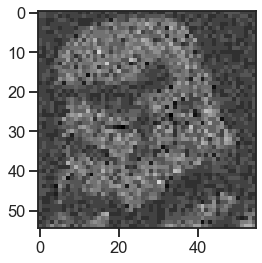

In [53]:
y_obs = genera_imagen()
plt.imshow(y_obs.reshape(N,-1), cmap = cmap_greys)

Nuestra tarea es encontrar $x$ como la solución de mínimos cuadrados de  la ecuación normal: $A x = y.$

El problema es que la matriz $A$ es una matriz muy mal condicionada y difícilmente invertible. 

In [57]:
print(r"Número de condición: " + r"\\kappa(A)" + ' = %.2e'%np.linalg.cond(A))

Número de condición: \\kappa(A) = 3.47e+05


## Resolviendo la ecuacion lineal

El sistema lineal $A x = y$ es sencillo dentro de lo que cabe. Por un lado, la matriz $A$ es cuadrada y mejor aún es simétrica positiva definida. Lo cual hace la inversión, al menos en papel, una operación realizable. Sin embargo, la presencia de los errores de transmisión dificultan el problema y es necesario resolver la función de pérdida cuadrática

$$\mathcal{L}(x) = \frac12 \|Ax - y \|^2\,.$$

Como lo hemos visto en clase, la solución se puede encontrar derivando (con respecto a $x$) e igualando a cero. Lo cual escribimos abajo. 

In [51]:
def solve(delta = 1.): 
    return np.linalg.solve(A.T.dot(A) + delta * np.eye(N**2), A.T.dot(y_noisy))

Sin embargo, como se muestra en el primer recuadro la solución de este sistema es sencillamente ininteligible (aún cuando el sujeto de la imagen parece ser facilmente reconocible). 

El problema es la presencia del ruido y también del condicionamiento de $A.$

Lo que necesitamos es minimizar la función de pérdida regularizada 

$$\mathcal{L}_R(x) = \frac12 \|Ax - y \|^2 + \frac{\delta}{2} \|x\|^2 \,.$$

El problema es encontrar un valor adecuado para $\delta,$ que en este caso lo ajustamos por medios visuales. Por ejemplo, el segundo cuadro de abajo representa una imagen útil. 

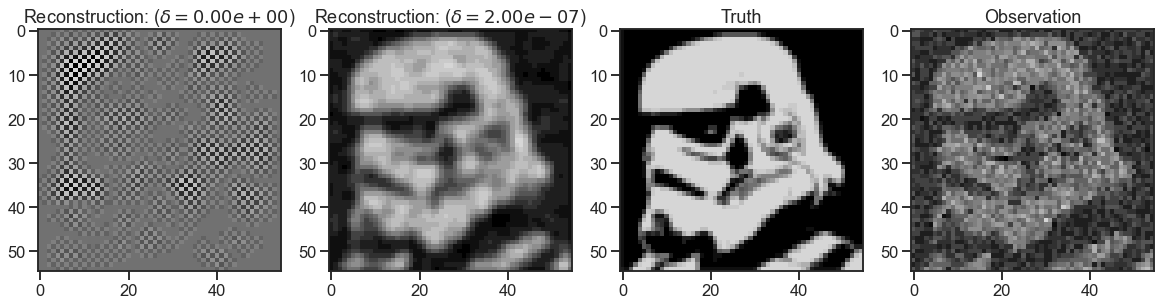

In [68]:
fig, axes = plt.subplots(1, 4, figsize = [20, 5])

axes[3].imshow(y_noisy.reshape(N,-1), cmap = cmap_greys)
axes[3].set_title(r'Observation');

delta_ = 0
axes[0].set_title(r'Reconstruction: ($\delta = %1.2e$)'%(delta_));
axes[0].imshow(solve(delta = delta_).reshape(N,-1), cmap = cmap_greys)

delta_ = 2e-7
axes[1].set_title(r'Reconstruction: ($\delta = %1.2e$)'%(delta_));
axes[1].imshow(solve(delta = delta_).reshape(N,-1), cmap = cmap_greys)

axes[2].imshow(image_y, cmap = cmap_greys)
axes[2].set_title(r'Truth');

Abajo muestro una selección de soluciones a distintos valores de $\delta.$ La solución parece estabilizarse rápido. 

  0%|          | 0/16 [00:00<?, ?it/s]

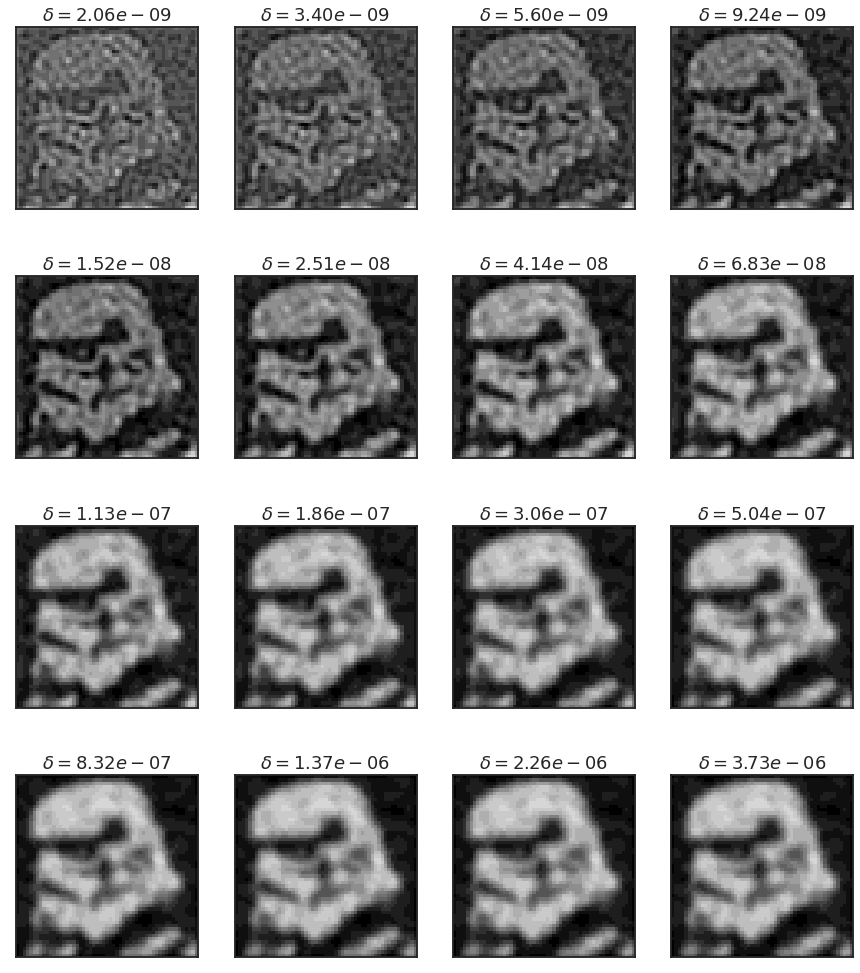

In [40]:
errors = []
deltas = np.exp(np.arange(-20, -12, .50))

fig, axes = plt.subplots(4, 4, figsize = [15, 15])
plt.subplots_adjust(bottom = 0.01, wspace = .2, hspace = .3)

for kk, ax in enumerate(tqdm(axes.flatten())):
    ax.set_title(r'$\delta = %1.2e$'%deltas[kk]);
    ax.set_yticks([]); ax.set_xticks([])
    
    solution = solve(delta = deltas[kk])
    errors.append(np.linalg.norm(A.T.dot(solution) - y))
    
    ax.imshow(solution.reshape(N,-1), cmap = cmap_greys)

La grafica de abajo muestra el error cuadrático. La leemos en sentido contrario a las graficas de complejidad que hemos visto anteriormente. En el extremo derecho se encuentran las soluciones menos flexibles (gran restricción en el tamaño de $x$) y en el extremo izquierdo soluciones altamente flexibles (que se engañan fácilmente con los datos).

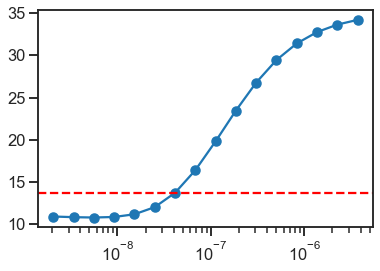

In [63]:
plt.plot(deltas, errors)
plt.scatter(deltas, errors)
plt.axhline(N*sigma_noise, linestyle = '--', color = 'red')
plt.xscale('log')

## Ejercicios

1. Revisa el código y el ejemplo en el libro de [Dive into Deep Learning](https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html). 
1. Resuelve los ejercicios de la sección 4.5.6 del libro. 

## Deconvolucion de imágenes$^\dagger$

En este secciones se ilustran las ideas del problema de inversión del operador de convolución aplicado a imágenes. Como hemos discutido esto ilustra la regularización de Tikhonov. 

Asumiremos que nuestro espacio de interés es un espacio Hilbert separable de dimensión finita con funciones integrables en el sentido cuadrático, $H_1 = H_2 = L^2(\mathbb{R}^2).$ La integrabilidad de la imagen esta garantizada al asumir que la función $f$ tiene soporte compacto. Asumiremos que el operador de convolución tiene un operador adjunto 
$$ A^*f(x) = \int \phi(y - x) \, f(y) \, \text{d}y\,.$$

Utilizaremos nucleos $\phi$ pares, es decir, $\phi(-x) = \phi(x),$ lo que implica que el operador es auto-adjunto $A = A^*.$ Esto garantiza que el operador esté bien definido y que tenga representación en series de Fourier. Más aún, garantiza que la regularizacion de Tikhonov tenga solución única. Para más detalles ver Capitulo 2 de [Kaipio y Somersalo](https://www.springer.com/gp/book/9780387220734).

Consideremos imagenes en el rectangulo unitario $[0,1] \times [0,1].$ La imagen verdadera $f$ es identicamente zero fuera de este rango. La imagen se divide en pixeles de áreas iguales donde $N$ denota el número de pixeles. Denotamos el centro del pixel por $p_{jk}.$ 

### Aproximación lineal

La aproximación que utilizaremos será 
$$A^*(p_{jk}) \approx \frac{1}{N^2} \sum_{l,m} \phi(p_{jk} - p_{lm}) \, f(p_{lm})\,,$$
que se puede expresar como un sistema lineal
$$Ax = y\,,$$
donde $x \in \mathbb{R}^{N^2}$ denota la imagen original organizada en un vector; $y\in \mathbb{R}^{N^2},$ la imagen suavizada (igual como vector largo) con el núcleo $\phi;$ y por último $A\in \mathbb{R}^{N^2\times N^2},$ el operador de convolución ordenado adecuadamente.

Consideraremos un nucleo de suavizamiento Gaussiano de la forma 
$$\phi(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left( -\frac{x^2}{2\sigma^2} \right)\,.$$